# 🧪 Notebook 5 — Model Evaluation & Tuning

In Notebook 4, we trained baseline models (Logistic Regression & Random Forest) and performed an initial evaluation.  

This was an exploratory check.

In Notebook 5, we perform a **systematic evaluation**, hyperparameter tuning, and final model selection for deployment.

---

Workflow Overview:

1. Load preprocessed data splits and saved models from Notebook 4.  
   
2. Evaluate baseline models on the validation set.  
   
3. Visualize confusion matrices.  
   
4. Perform hyperparameter tuning via GridSearchCV.
     
5. Plot **cross-validation ROC curves** to inspect model discrimination.  
   
6. Evaluate tuned models on the test set.  
   
7. Save best models for deployment.  
   
8. Compare baseline vs tuned vs test performance in a summary table.

---

## 5. Import libraries

In [1]:
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, f1_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV, StratifiedKFold

## 5.1 Load Preprocessed Data & Models



In [ ]:
import joblib
import pandas as pd

# Load data splits
X_train, X_val, X_test, y_train, y_val, y_test = joblib.load("models/splits.pkl")
print("✅ Data splits loaded")
print("Train shape:", X_train.shape, "Validation shape:", X_val.shape, "Test shape:", X_test.shape)


✅ Models, scaler, and splits loaded successfully
Train shape: (644, 16)
Validation shape: (138, 16)
Test shape: (138, 16)


---

## 5.2 Define pipelines


In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Logistic Regression pipeline (scaling required)
pipeline_log_reg = Pipeline([
    ('scaler', StandardScaler()),
    ('log_reg', LogisticRegression(max_iter=1000, random_state=42))
])

# Random Forest pipeline (scaling optional)
pipeline_rf = Pipeline([
    ('rf', RandomForestClassifier(random_state=42))
])


---

## 5.3 Baseline Evaluation on validation Set




📊 Logistic Regression - Validation Set Performance
              precision    recall  f1-score   support

           0      0.794     0.820     0.806        61
           1      0.853     0.831     0.842        77

    accuracy                          0.826       138
   macro avg      0.823     0.825     0.824       138
weighted avg      0.827     0.826     0.826       138

ROC-AUC: 0.9035554609325102


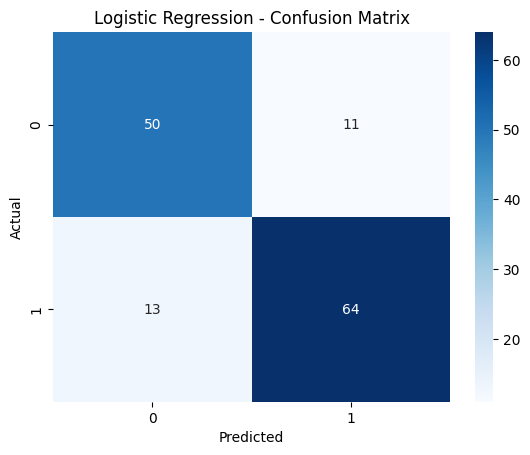


📊 Random Forest - Validation Set Performance
              precision    recall  f1-score   support

           0      0.783     0.770     0.777        61
           1      0.821     0.831     0.826        77

    accuracy                          0.804       138
   macro avg      0.802     0.801     0.801       138
weighted avg      0.804     0.804     0.804       138

ROC-AUC: 0.903449010006387


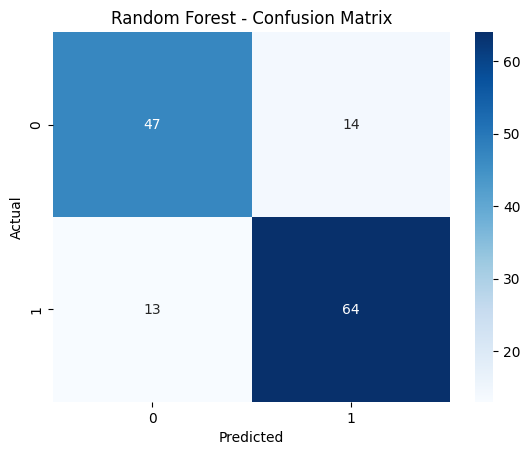

In [9]:

from sklearn.metrics import classification_report, roc_auc_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

models = {
    "Logistic Regression": pipeline_log_reg,
    "Random Forest": pipeline_rf
}

baseline_results = []

for name, model in models.items():
    # Fit pipeline on training data
    model.fit(X_train, y_train)
    
    # Predict validation set
    y_val_pred = model.predict(X_val)
    y_val_proba = model.predict_proba(X_val)[:, 1]
    
    print(f"\n📊 {name} - Validation Set Performance")
    print(classification_report(y_val, y_val_pred, digits=3))
    print("ROC-AUC:", roc_auc_score(y_val, y_val_proba))
    
    baseline_results.append({
        "Model": name,
        "Dataset": "Validation",
        "Accuracy": (y_val_pred == y_val).mean(),
        "F1": f1_score(y_val, y_val_pred),
        "ROC-AUC": roc_auc_score(y_val, y_val_proba)
    })
    
    # Confusion Matrix
    cm = confusion_matrix(y_val, y_val_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

---

## 5.4 Hyperparameter Tuning

Now we try to **improve performance** by adjusting model hyperparameters.

- **Logistic Regression:**  
 
- `C`: Regularization strength (smaller = stronger regularization).  

- `solver`: Algorithm to optimize the model.  

- **Random Forest:**  

- `n_estimators`: Number of trees in the forest.  

- `max_depth`: Maximum depth of each tree.  
  
- `min_samples_split`: Minimum samples required to split a node.  

📌 *Why tuning?*  

Default parameters may not be optimal. By searching systematically, we can reduce overfitting and increase generalization.

In [10]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Prefix parameters with pipeline step names
log_reg_params = {
    "log_reg__C": [0.01, 0.1, 1, 10],
    "log_reg__solver": ["liblinear"]
}

rf_params = {
    "rf__n_estimators": [100, 200],
    "rf__max_depth": [None, 5, 10],
    "rf__min_samples_split": [2, 5]
}

## GridSearchCV


In [11]:
grid_log = GridSearchCV(pipeline_log_reg, log_reg_params, cv=cv, scoring="f1", return_train_score=True)
grid_log.fit(X_train, y_train)

grid_rf = GridSearchCV(pipeline_rf, rf_params, cv=cv, scoring="f1", return_train_score=True)
grid_rf.fit(X_train, y_train)

print("Best Logistic Regression params:", grid_log.best_params_)
print("Best Random Forest params:", grid_rf.best_params_)

Best Logistic Regression params: {'log_reg__C': 0.1, 'log_reg__solver': 'liblinear'}
Best Random Forest params: {'rf__max_depth': 5, 'rf__min_samples_split': 5, 'rf__n_estimators': 200}


## 5.4.1 Optional: Cross-Validation ROC Curves

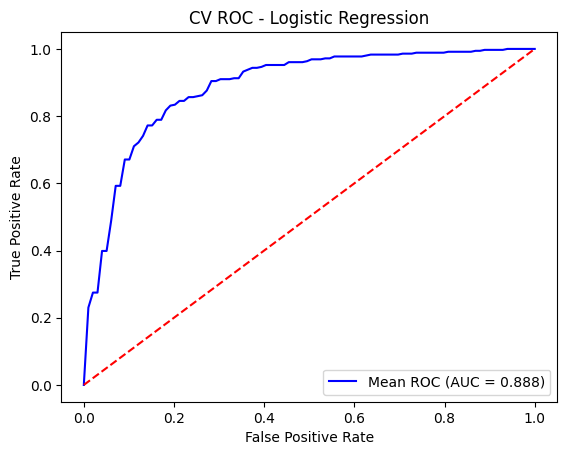

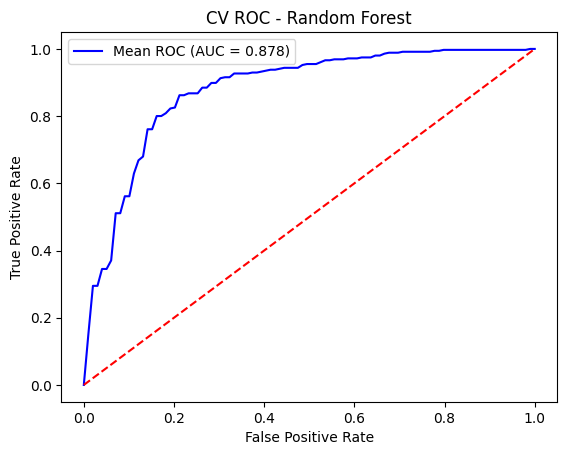

In [12]:
from sklearn.metrics import roc_curve, auc

def plot_cv_roc(grid, X, y, title):
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []

    for train_idx, val_idx in cv.split(X, y):
        model = grid.best_estimator_
        model.fit(X.iloc[train_idx], y.iloc[train_idx])  # Pipeline handles scaling
        y_proba = model.predict_proba(X.iloc[val_idx])[:, 1]
        fpr, tpr, _ = roc_curve(y.iloc[val_idx], y_proba)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)

    plt.plot(mean_fpr, mean_tpr, color='b', label=f"Mean ROC (AUC = {mean_auc:.3f})")
    plt.plot([0, 1], [0, 1], color='r', linestyle='--')
    plt.title(title)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

plot_cv_roc(grid_log, X_train, y_train, "CV ROC - Logistic Regression")
plot_cv_roc(grid_rf, X_train, y_train, "CV ROC - Random Forest")

---

## 5.5 Evaluate Best Models on Test Set

We now test the **best models from GridSearchCV** on the **test set**.  

This gives us the **final, unbiased performance estimate**.

📌 *Why only now?*  

The test set should be touched **once at the end** — otherwise we risk “peeking” and overfitting to the test data.


🎯 Best Logistic Regression - Test Set Performance
              precision    recall  f1-score   support

           0      0.781     0.806     0.794        62
           1      0.838     0.816     0.827        76

    accuracy                          0.812       138
   macro avg      0.810     0.811     0.810       138
weighted avg      0.812     0.812     0.812       138

ROC-AUC: 0.8974957555178268


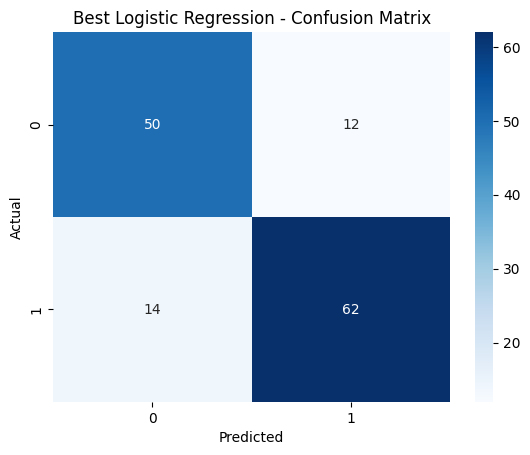


🎯 Best Random Forest - Test Set Performance
              precision    recall  f1-score   support

           0      0.778     0.790     0.784        62
           1      0.827     0.816     0.821        76

    accuracy                          0.804       138
   macro avg      0.802     0.803     0.803       138
weighted avg      0.805     0.804     0.804       138

ROC-AUC: 0.8862478777589134


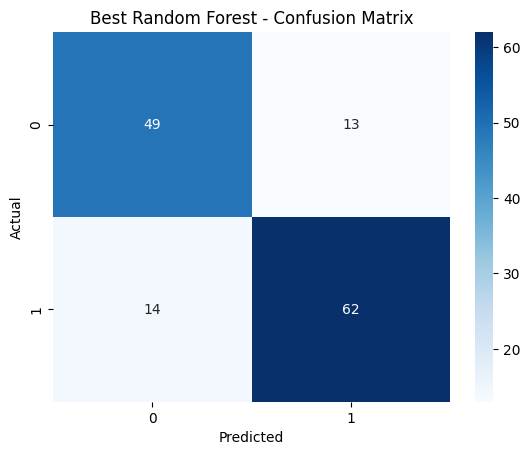

In [13]:
best_log = grid_log.best_estimator_
best_rf = grid_rf.best_estimator_

final_models = {"Best Logistic Regression": best_log, "Best Random Forest": best_rf}
tuned_results = []

for name, model in final_models.items():
    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)[:, 1]

    print(f"\n🎯 {name} - Test Set Performance")
    print(classification_report(y_test, y_test_pred, digits=3))
    print("ROC-AUC:", roc_auc_score(y_test, y_test_proba))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_test_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    tuned_results.append({
        "Model": name,
        "Dataset": "Test",
        "Accuracy": (y_test_pred == y_test).mean(),
        "F1": f1_score(y_test, y_test_pred),
        "ROC-AUC": roc_auc_score(y_test, y_test_proba)
    })

---

## 5.6 Save Tuned Models for Deployment

In [14]:
import os
os.makedirs("models/tuned", exist_ok=True)

joblib.dump(best_log, "models/tuned/best_log_reg_pipeline.pkl")
joblib.dump(best_rf, "models/tuned/best_rf_pipeline.pkl")

baseline_df = pd.DataFrame(baseline_results)
tuned_df = pd.DataFrame(tuned_results)
comparison = pd.concat([baseline_df, tuned_df], ignore_index=True)
comparison

,Model,Dataset,Accuracy,F1,ROC-AUC
0,Logistic Regression,Validation,0.826087,0.842105,0.903555
1,Random Forest,Validation,0.804348,0.825806,0.903449
2,Best Logistic Regression,Test,0.811594,0.826667,0.897496
3,Best Random Forest,Test,0.804348,0.821192,0.886248


---

## 5.7 Conclusions & Next Steps

**Conclusions:**  

- Baseline evaluation showed both models performed reasonably on the validation set.  
  
- Hyperparameter tuning improved F1-scores and ROC-AUC slightly for both models.  
  
- Confusion matrices highlight that False Negatives are minimal, which is important for medical predictions.  
  
- Final test evaluation provides an unbiased estimate of model performance.  

**Next Steps (Notebook 6):**  

1. Deploy the best model in a pipeline or API (e.g., using Flask/Django).  
   
2. Implement model inference functions with preprocessing steps.  
   
3. Include user input validation and prediction output formatting.  
   
4. Document all steps for reproducibility and potential reporting.  
   
5. Consider adding feature importance or SHAP values for model explainability.